In [1]:
import numpy as np 
from tensorflow.keras.applications import imagenet_utils, mobilenet
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
import seaborn as sns
import os

%matplotlib inline

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
def extracting_images(path):
    """
    extracting folders of training and vallidation and testing from zip file
    """
    with ZipFile(path+'.zip','r') as zip:
            print("extracting_training_images.....")
            zip.extractall(path)
            print("extracting_finished!")
            zip.close()

In [5]:
data_path="/content/drive/My Drive/Colab Notebooks/liveness_detection/datasets/real_datav2"
# extracting_images(data_path)
train_path=data_path+'/real_data/train'
valid_path=data_path+'/real_data/valid'
test_path=data_path+'/real_data/test'

train_batches=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=train_path,target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 11081 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [6]:
model = mobilenet.MobileNet()
# model.summary()

17227776/17225924 [==============================] - 0s 0us/step


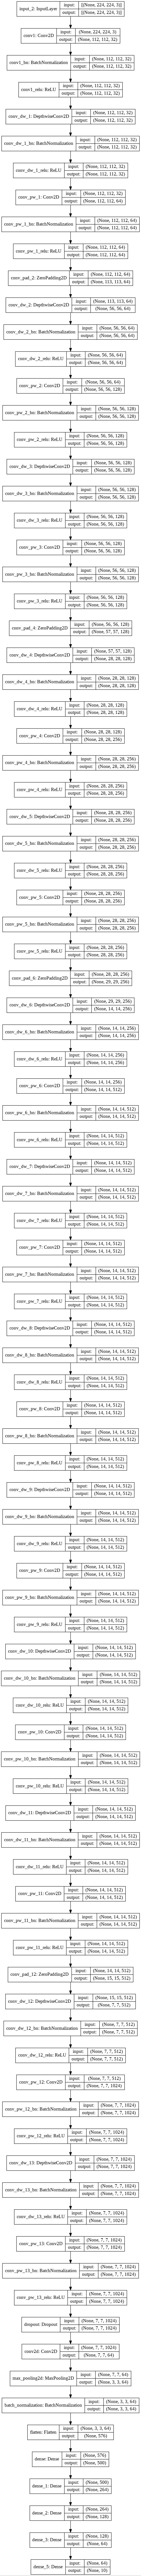

In [7]:
from keras.utils.vis_utils import plot_model
model = mobilenet.MobileNet()
x=model.layers[-7].output
x = Dropout(0.4)(x)
x = Conv2D(64,(3,3),padding='same',activation= 'relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)  
x = Flatten()(x)                  #flatten the outpt by above layers

x = Dense(500,input_dim=2,activation= 'relu')(x)  
x = Dense(264, input_dim=2, activation='relu')(x)
x = Dense(128, input_dim=2, activation='relu')(x)
x = Dense(64, input_dim=2, activation='relu')(x)
output=Dense(units=10,activation='softmax')(x)
output=Dense(units=10,activation='softmax')(x)
model=Model(inputs=model.input,outputs=output)
# model.summary()
plot_model(model, to_file=os.path.join('/content/drive/My Drive/Colab Notebooks/liveness_detection/pic','model_plot_mobilenet.jpg'), show_shapes=True, show_layer_names=True)

In [8]:
for layer in model.layers[:-20]:
 layer.trainable=False

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.994):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [10]:
model.compile(optimizer=Adam(learning_rate=.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=100,verbose=2, callbacks= myCallback())

Epoch 1/100
1109/1109 - 5133s - loss: 0.1793 - accuracy: 0.9518 - val_loss: 0.0406 - val_accuracy: 0.9940

Reached 99.0% accuracy so cancelling training!


In [41]:
def plot_confusion_matrix():
  predections = loding_model.predict(x=test_batches,verbose=0)
  y_test_pred = np.argmax(predections, axis =1)
  y_test = test_batches.classes 
  confusion_mtx = confusion_matrix(y_test, y_test_pred) 
  plt.figure(figsize = (10,10)) #y_true and predictied
  sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  # plt.savefig(os.path.join('/content/drive/My Drive/Colab Notebooks/liveness_detection/pic','confusion_matrix_mobilenet.jpg'))
  plt.show()

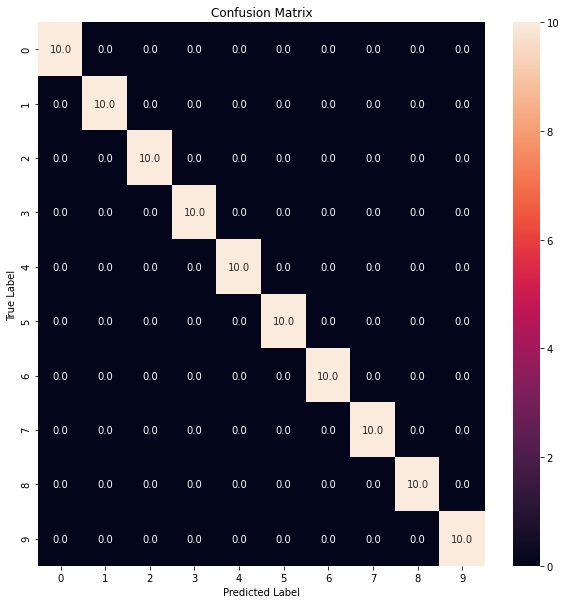

In [17]:
plot_confusion_matrix()

In [39]:
wights_path="/content/drive/My Drive/Colab Notebooks/liveness_detection/model"

if os.path.isfile(os.path.join(wights_path, 'Gesture recognition_Sign Language_mobilenet_v5')) is False:
  model.save(os.path.join(wights_path, 'Gesture recognition_Sign Language_mobilenet_v5'))


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/liveness_detection/model/Gesture recognition_Sign Language_mobilenet_v5/assets


In [51]:
model = load_model(os.path.join(wights_path, 'Gesture recognition_Sign Language_mobilenet'))
y_predict = np.argmax(model.predict(test_batches), axis=1)
print(y_predict)

[0 4 0 0 0 0 4 0 0 4 1 4 4 4 8 4 4 4 4 4 4 1 4 4 4 4 4 4 0 0 5 4 5 3 4 5 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 7 4 4 4
 4 4 4 4 4 4 4 4 8 8 8 8 4 4 4 4 4 4 4 4 4 4 4 4 5 9]


 now we need check our model on data that hasn't white background 

---



In [28]:
data_path="/content/drive/My Drive/Colab Notebooks/liveness_detection/datasets/real_datav3"
# extracting_images(data_path)
train_path=data_path+'/real_datav2/train'
valid_path=data_path+'/real_datav2/valid'
test_path=data_path+'/real_datav2/test'

train_batches=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=train_path,target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 9391 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


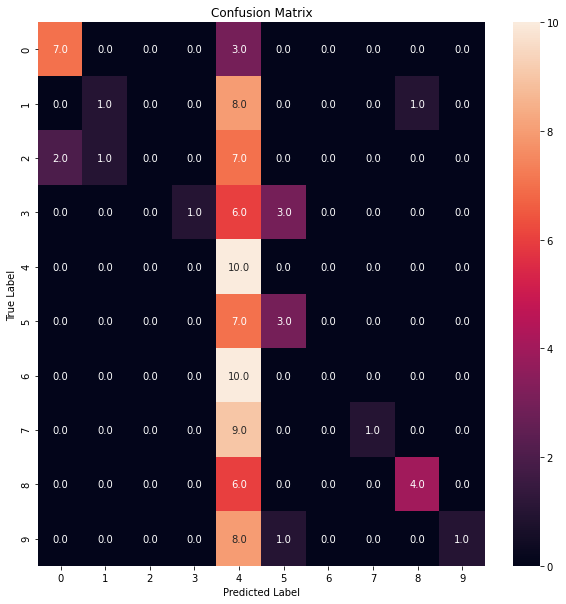

In [48]:
predections = model.predict(x=test_batches,verbose=0)
y_test_pred = np.argmax(predections, axis =1)
y_test = test_batches.classes 
confusion_mtx = confusion_matrix(y_test, y_test_pred) 
plt.figure(figsize = (10,10)) #y_true and predictied
sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join('/content/drive/My Drive/Colab Notebooks/liveness_detection/pic','confusion_matrix_mobilenet_bad.jpg'))
plt.show()



---


as we saw the results is  horible results

so we need to retrain the model on images that hasn't white background

In [55]:
model.compile(optimizer=Adam(learning_rate=.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=100,verbose=2, callbacks= myCallback())

Epoch 1/100
940/940 - 2021s - loss: 0.0068 - accuracy: 0.9977 - val_loss: 2.0591e-04 - val_accuracy: 1.0000

Reached 99.0% accuracy so cancelling training!


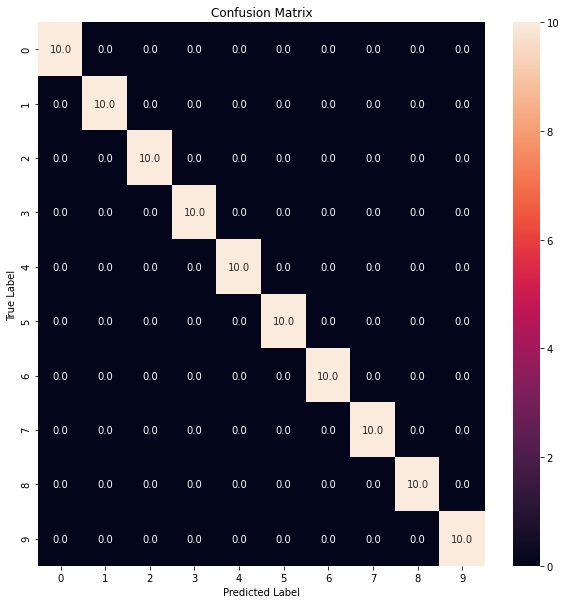

In [56]:
plot_confusion_matrix()

as we saw the results is very good

In [58]:
wights_path="/content/drive/My Drive/Colab Notebooks/liveness_detection/model"

if os.path.isfile(os.path.join(wights_path, 'Gesture recognition_Sign Language_mobilenet_v6')) is False:
  loding_model.save(os.path.join(wights_path, 'Gesture recognition_Sign Language_mobilenet_v6'))

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/liveness_detection/model/Gesture recognition_Sign Language_mobilenet_v6/assets
